In [1]:
import torch

from helper import linear_q_symmetric, get_q_scale_symmetric, linear_q_with_scale_and_zero_point, linear_dequantization
from helper import plot_quantization_errors, quantization_error

# Finer Granularity for more Precision
The more granular the quantization is the more accurate it will be. However note that it requires more memory since we need to store more quantization parameters. There are different granularities when it comes to quantization. We have per tensor quantization, but we don’t have to use the same scale and zero point for a whole tensor. We can for instance calculate a scale and the zero point for each axis, this is called per channel quantization. We could also choose a group of n elements to get the scale and zero point, and quantize each group with its own scale and zero point.

In [2]:
# test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]])

In [3]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [4]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

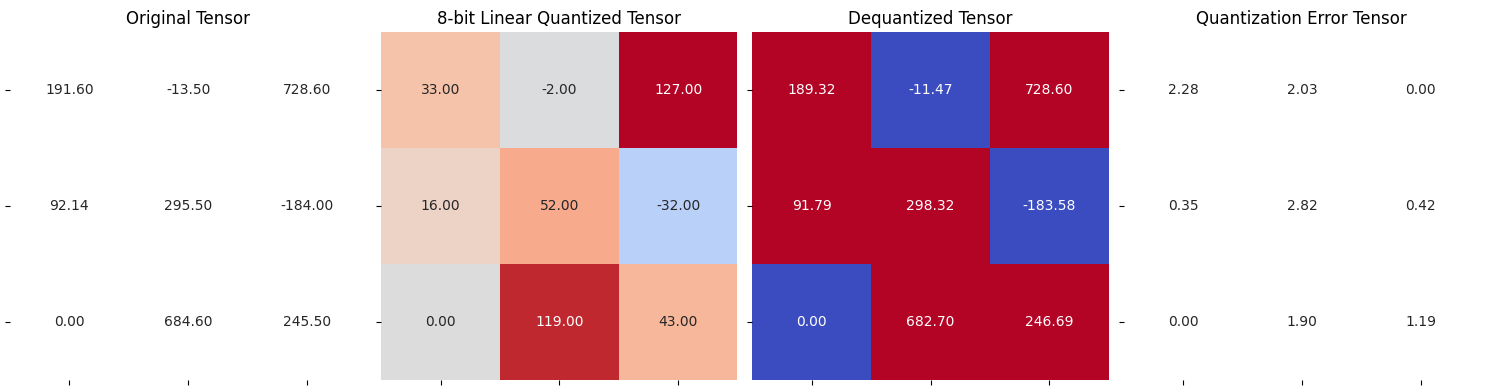

In [5]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [6]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.5091912746429443


## Per Channel Quantization
We need to store the scales and the zero point for each row if we decide to quantize along the rows and we need to store them along each column if we decide to quantize along the columns. The memory needed to store all these linear parameters is pretty small. We usually use per channel quantization when quantizing models in 8-bit.

In [7]:
def linear_q_symmetric_per_channel(tensor,dim,dtype=torch.int8):
    return quantized_tensor, scale

In [8]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]])

- dim = 0, along the rows
- dim = 1, along the columns

In [9]:
dim=0
output_dim = test_tensor.shape[dim]

In [10]:
output_dim

3

In [11]:
scale = torch.zeros(output_dim)
scale

tensor([0., 0., 0.])

In [12]:
#Iterate through each row to calculate its scale
for index in range(output_dim):
    sub_tensor = test_tensor.select(dim,index)
    scale[index] = get_q_scale_symmetric(sub_tensor)

In [13]:
scale

tensor([5.7370, 2.3268, 5.3906])

We now manage to store the scales related to each row inside a tensor. After this we need to do a little bit processing in order to reshape the scale so that when we divide the original tensor by the tensor scale, each column is divided by the correct scale.

In [14]:
scale_shape = [1]*test_tensor.dim()
scale_shape

[1, 1]

In [15]:
scale_shape[dim] = -1
scale_shape

[-1, 1]

In [16]:
copy_scale = scale.view(scale_shape)
copy_scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

## Understanding tensor-by-tensor division

In [17]:
m = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [18]:
s = torch.tensor([1,5,10])
s

tensor([ 1,  5, 10])

In [19]:
s.shape

torch.Size([3])

In [20]:
s.view(1, 3).shape

torch.Size([1, 3])

In [21]:
#altenative method
s.view(1, -1).shape

torch.Size([1, 3])

## Division along the rows

In [22]:
scale = torch.tensor([[1], [5], [10]])

In [23]:
scale.shape

torch.Size([3, 1])

In [24]:
m / scale

tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]])

## Division along the columns

In [25]:
scale = torch.tensor([[1, 5, 10]])

In [26]:
scale.shape

torch.Size([1, 3])

In [27]:
m / scale

tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]])

## Back to Quantizing the Tensor

In [28]:
# the scale we got earlier
scale = copy_scale
scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

In [29]:
scale.shape

torch.Size([3, 1])

As we are performing symmetric quantization, hence z=0.

In [30]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale=scale, zero_point=0)
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

Putting everything we did in a function `linear_q_symmetric_per_channel`.

In [31]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)

    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)
   
    return quantized_tensor, scale

In [32]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]])

In [33]:
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(test_tensor, dim=0)

### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(test_tensor, dim=1)

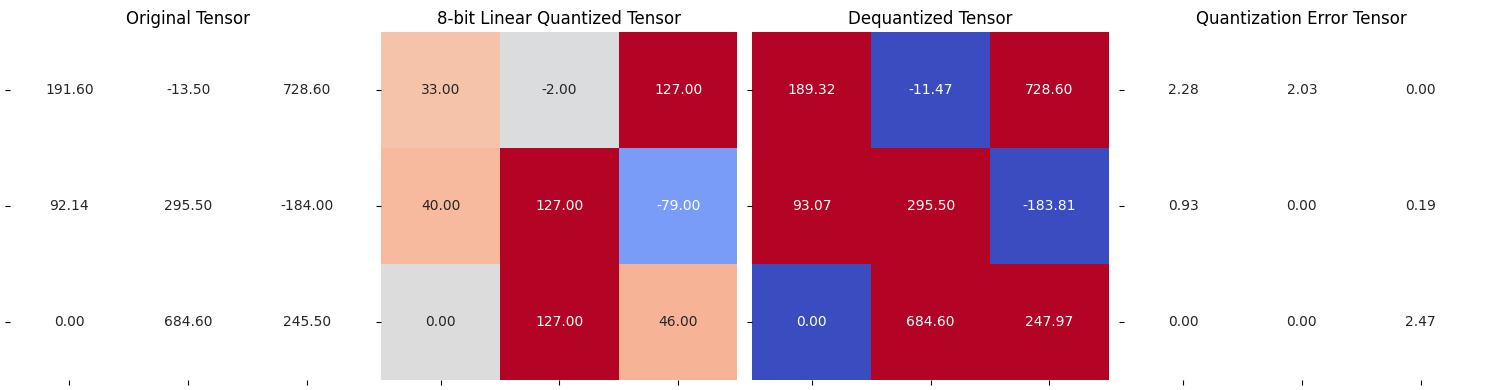

In [34]:
dequantized_tensor_0 = linear_dequantization(quantized_tensor_0, scale_0, 0)

plot_quantization_errors(test_tensor, quantized_tensor_0, dequantized_tensor_0)

In [35]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_0)}""")

Quantization Error : 1.8084441423416138


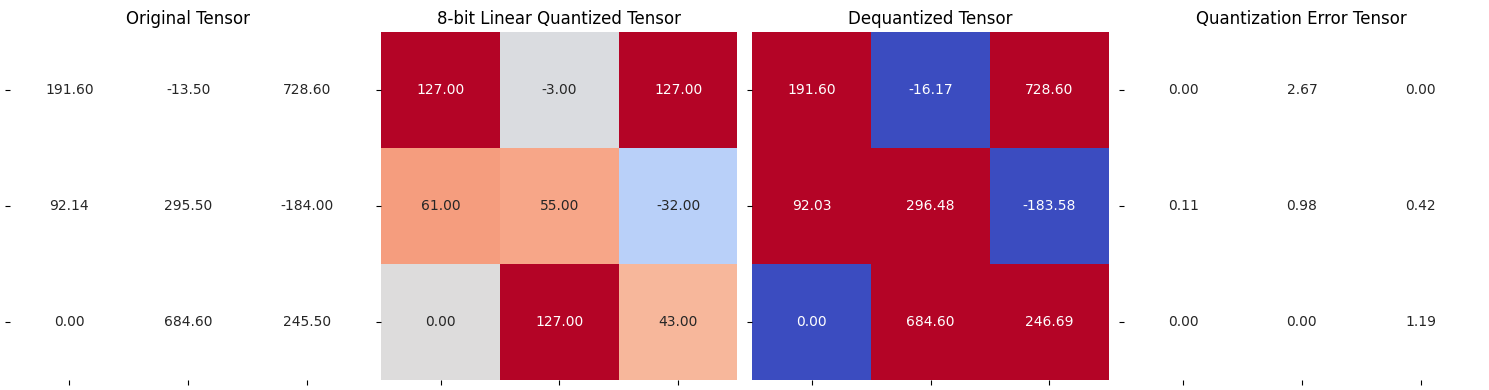

Quantization Error : 1.0781488418579102


In [36]:
dequantized_tensor_1 = linear_dequantization(quantized_tensor_1, scale_1, 0)

plot_quantization_errors(test_tensor, quantized_tensor_1, dequantized_tensor_1, n_bits=8)

print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_1)}""")

In previous case we got an error of **2.5**, while quantizing along rows we got an error of **1.81** and along columns we are getting **1.08**. This is because the outlier values will only impact the channel it was in, instead of the entire tensor.

## Per Group Quantization
Now let’s go even smaller and perform group quantization. Here we perform quantization on groups of n elements. Common values for n are **32, 64, 128**. Per group can require a lot of memory. If we want to quantize a tensor in **4-bit** and we choose a group size equal to **32**. We use symmetric mode (z=0), and we store the s in FP16. It means that we are quantizing the tensor in **4.5-bits**.<br>
- Since we have 4-bit (each element is stored using 4-bit)
- And we have 16 / 32 bit (scale in 16 bits for every 32 elements).

In [37]:
def linear_q_symmetric_per_group(tensor, group_size, dtype=torch.int8):
    
    t_shape = tensor.shape
    assert t_shape[1] % group_size == 0
    assert tensor.dim() == 2
    
    tensor = tensor.view(-1, group_size)
    
    quantized_tensor, scale = linear_q_symmetric_per_channel(tensor, dim=0, dtype=dtype)
    
    quantized_tensor = quantized_tensor.view(t_shape)
    
    return quantized_tensor, scale

In [38]:
def linear_dequantization_per_group(quantized_tensor, scale, group_size):
    
    q_shape = quantized_tensor.shape
    quantized_tensor = quantized_tensor.view(-1, group_size)
    
    dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)
    
    dequantized_tensor = dequantized_tensor.view(q_shape)
    
    return dequantized_tensor

In [39]:
test_tensor = torch.rand((6, 6))

In [40]:
group_size = 3

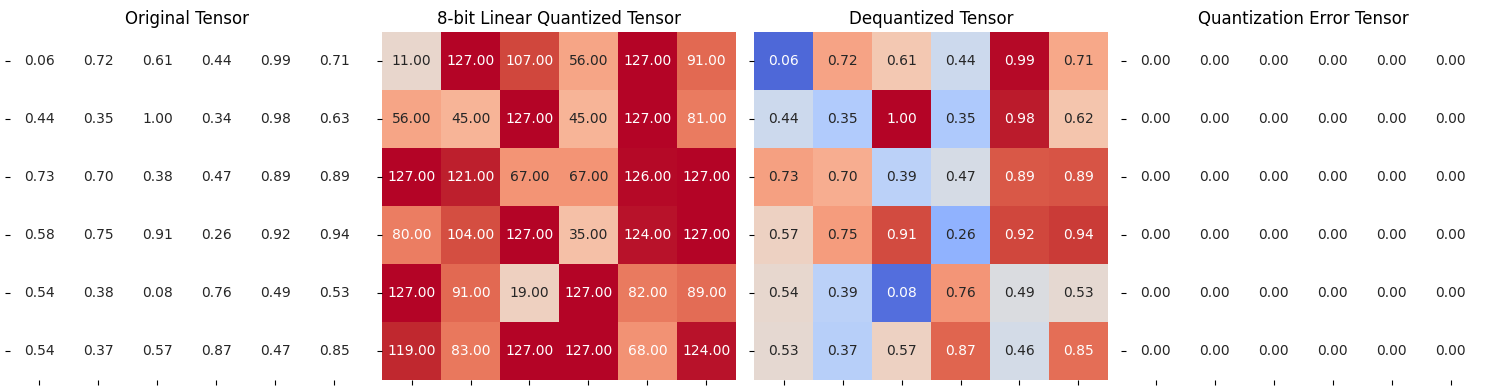

In [41]:
quantized_tensor, scale = linear_q_symmetric_per_group(
    test_tensor, group_size=group_size)

dequantized_tensor = linear_dequantization_per_group(
    quantized_tensor, scale, group_size=group_size)

plot_quantization_errors(
    test_tensor, quantized_tensor, dequantized_tensor)

In [42]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.731435415626038e-06


If we see in the quantized tensor, three elements in the matrix along rows we have the maximum value 127. Which shows that we indeed manage to quantize each three elements in the matrix along rows. Also we can see that the quantization error is very very low. 

# Quantizing Weights & Activations for Inference
How to perform inference with linear quantization? If we only quantize weights the computation will be using FP arithmetic (FP32, FP16, BFP16). Here we need to dequantize the weights to perform the FP computation. If we also quantize activation we will be using integer arithmetic (INT8, INT4, etc). But this is not supported by all hardware.

In [43]:
import torch
from helper import linear_q_symmetric, get_q_scale_symmetric

Let's see how the linear layer will be if we only quantize weights not the activations.
- `W8A32` means weights in 8-bits and activations in 32-bits.
- For simplicity, the linear layer will be without bias.

In [44]:
def quantized_linear_W8A32_without_bias(input, q_w, s_w, z_w):
    assert input.dtype == torch.float32
    assert q_w.dtype == torch.int8

    dequantized_weight = q_w.to(torch.float32) * s_w + z_w
    output = torch.nn.functional.linear(input, dequantized_weight)
    
    return output

In [45]:
input = torch.tensor([1, 2, 3], dtype=torch.float32)

In [46]:
weight = torch.tensor([[-2,   -1.13, 0.42],
                       [-1.51, 0.25, 1.62],
                       [0.23,  1.35, 2.15]])

We will quantize the sample weights

In [47]:
q_w, s_w  = linear_q_symmetric(weight)

In [48]:
q_w

tensor([[-118,  -67,   25],
        [ -89,   15,   96],
        [  14,   80,  127]], dtype=torch.int8)

In [49]:
s_w

0.016929134609192376

In [50]:
output = quantized_linear_W8A32_without_bias(input, q_w, s_w, 0)

In [51]:
print(f"This is the W8A32 output: {output}")

This is the W8A32 output: tensor([-2.9965,  3.8768,  9.3957])


In [52]:
fp32_output = torch.nn.functional.linear(input, weight)
print(f"This is the output if we don't quantize: {fp32_output}")

This is the output if we don't quantize: tensor([-3.0000,  3.8500,  9.3800])
